<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/Kaggle_nyc_taxi_trip_duration_%ED%94%8C%EC%A0%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from math import sin, cos, sqrt, atan2, radians
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [25]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')
train.shape, test.shape, submit.shape

((1458644, 11), (625134, 9), (625134, 2))

Text(0.5, 1.0, 'Distribution After log1p')

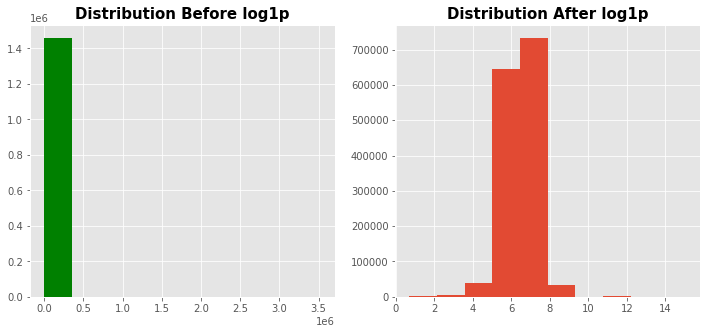

In [ ]:
# target변수에 log1p를 할 것.
fig, ax = plt.subplots(1,2, figsize=(12,5))
train['trip_duration'].hist(ax=ax[0], color='green')
ax[0].set_title('Distribution Before log1p', fontsize=15, fontweight='bold')
np.log1p(train['trip_duration']).hist(ax=ax[1])
ax[1].set_title('Distribution After log1p', fontsize=15, fontweight='bold')

# 만들 columns 

1. distance(pickup_lon - dropoff_lon, pickup_lat-dropoff_lat, np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat'])))
2. clustering
3. speed(100000*train['dist'] / train['trip_duration'])  ==> test는 못 만드니까 지워야 함
4. 시계열 columns (pickup 시계열로)

---
# Feature Engineering


In [26]:
# 시계열 컬럼
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
train['weekday'] = train['pickup_datetime'].dt.weekday
train['weekend'] = train['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['weekday'] = test['pickup_datetime'].dt.weekday
test['weekend'] = test['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

In [27]:
# store_and_fwd_flag FE
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N':0, 'Y':1}).astype('object')
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({'N':0, 'Y':1}).astype('object')

In [28]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])

    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat

    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

def feature_construct(df):
  # distance feautres
  df['dist_long'] = df['pickup_longitude'] - df['dropoff_longitude']
  df['dist_lat'] = df['pickup_latitude'] - df['dropoff_latitude']
  df['dist'] = np.sqrt(np.square(df['dist_long']) + np.square(df['dist_lat']))
  

  df['dist_long'] = np.abs(df['dist_long'])
  df['dist_lat'] = np.abs(df['dist_lat'])

  # 어디에서 어디까지 탔는가를 value_counts() ==> 구간별로 걸리는 시간(trip_duration)이 다를수도 있기 때문
  df['pickup_longitude_bin'] = np.round(df['pickup_longitude'], 3)  # 그런데 위경도가 너무 크지 않나...? 
  df['pickup_latitude_bin'] = np.round(df['pickup_latitude'], 3)
  df['dropoff_longitude_bin'] = np.round(df['dropoff_longitude'], 3)
  df['dropoff_latitude_bin'] = np.round(df['dropoff_latitude'], 3)

  # df['pickup_longitude_bin'] = np.round(df['pickup_longitude'], 2)  # 그런데 위경도가 너무 크지 않나...? 
  # df['pickup_latitude_bin'] = np.round(df['pickup_latitude'], 2)
  # df['dropoff_longitude_bin'] = np.round(df['dropoff_longitude'], 2)
  # df['dropoff_latitude_bin'] = np.round(df['dropoff_latitude'], 2)

  # distance 구하기
  df['bearing_distance'] = df.apply(lambda x: calculateBearing(x['pickup_latitude_bin'], x['pickup_longitude_bin'], x['dropoff_latitude_bin'], x['dropoff_longitude_bin']), axis=1)
  df['cal_distance'] = df.apply(lambda x: calculateDistance(x), axis=1)


  return df

In [29]:
train = feature_construct(train)
test = feature_construct(test)

In [30]:
a = pd.concat([train,test]).groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).size().reset_index(name='bin_valuecounts')
b = pd.concat([train,test]).groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).size().reset_index(name='bin_valuecounts')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')

train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bearing_distance,cal_distance,bin_valuecounts_x,bin_valuecounts_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,98.823984,1.498991,5256,602
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,-119.053505,1.806074,1010,394
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,-159.948291,6.387103,1132,264
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,-173.347990,1.485965,1190,636
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,180.000000,1.188962,1482,442


In [31]:
# speed columns 이용
train['speed'] = 100000*train['dist'] / train['trip_duration']

In [32]:
a = train.groupby(['pickup_longitude_bin', 'pickup_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')
b = train.groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bearing_distance,cal_distance,bin_valuecounts_x,bin_valuecounts_y,speed,avg_speed_x,avg_speed_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,98.823984,1.498991,5256,602,3.885613,3.347062,3.354606
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,-119.053505,1.806074,1010,394,3.085355,3.678684,3.408484
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,-159.948291,6.387103,1132,264,2.821742,3.317220,4.552624
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,-173.347990,1.485965,1190,636,3.132449,4.069836,4.190553
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,180.000000,1.188962,1482,442,2.457372,4.437244,4.029664


In [33]:
# clustering
from sklearn.cluster import KMeans

longi = np.vstack((train[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  train[['dropoff_longitude_bin', 'dropoff_latitude_bin']],
                  test[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  test[['dropoff_longitude_bin', 'dropoff_latitude_bin']]))
# Elbow method
sse = {}
for i in range(1,11, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=42).fit(longi)
  sse[i] = km.inertia_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



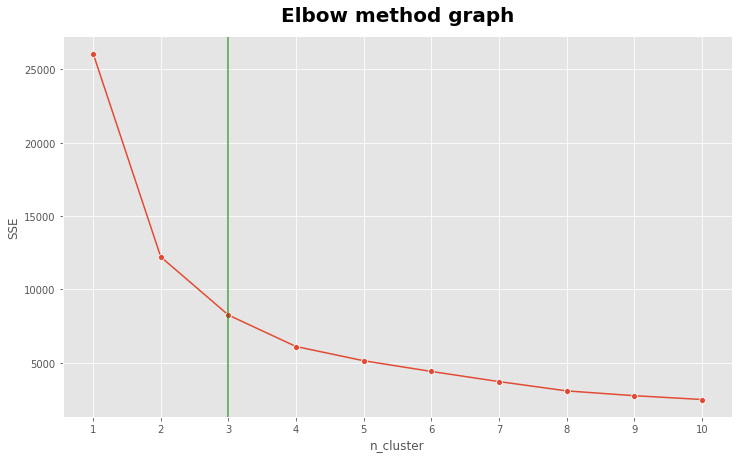

In [87]:
plt.figure(figsize=(12,7))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.ylabel('SSE')
plt.xlabel('n_cluster')
plt.xticks(pd.Series(sse).index)
plt.title('Elbow method graph', fontsize=20, pad=15, fontweight='bold')
# 
plt.axvline(x=4, color='green', alpha=0.7)

Text(0.5, 1.0, 'scatter map for clustering')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



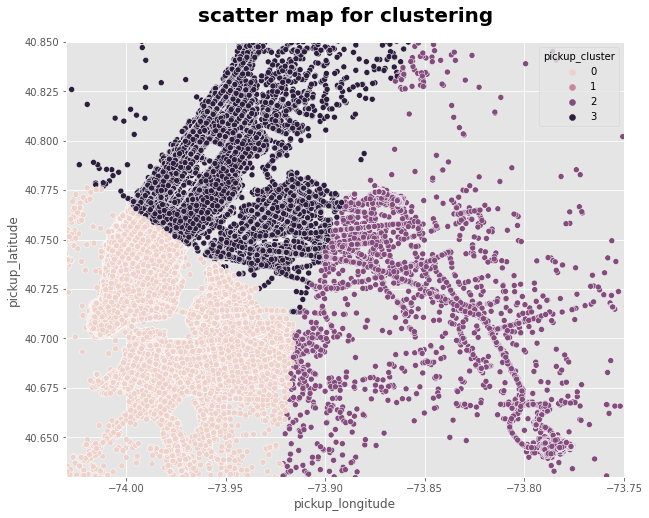

In [35]:
# predict
km = KMeans(n_clusters=4, max_iter=1000, random_state=42).fit(longi)

train['pickup_cluster'] = km.predict(train[['pickup_longitude_bin', 'pickup_latitude_bin']])
train['dropoff_cluster'] = km.predict(train[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

test['pickup_cluster'] = km.predict(test[['pickup_longitude_bin', 'pickup_latitude_bin']])
test['dropoff_cluster'] = km.predict(test[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

# visualize
plt.figure(figsize=(10,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'], hue=train['pickup_cluster'], data=train)
plt.xlim((-74.03, -73.75))
plt.ylim((40.63, 40.85))
plt.title('scatter map for clustering', fontsize=20, pad=20, fontweight='bold')

# Data preprocessing

In [36]:
# data split
x_train = train.drop(columns=['id', 'trip_duration', 'pickup_datetime', 'dropoff_datetime', 'speed', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
y_train = np.log1p(train['trip_duration'])  # 타겟에 log1p 
x_test = test.drop(columns=['id', 'pickup_datetime', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
x_train_columns, x_test_columns = x_train.columns, x_test.columns
x_train.shape, x_test.shape

((1458644, 24), (625134, 24))

In [37]:
# scaling
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

# Modeling (Catboost) - 라이브러리 설치 ↓↓↓↓↓↓↓

In [15]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 45 kB/s 
     |████████████████████████████████| 302 kB 16.5 MB/s 
     |████████████████████████████████| 164 kB 61.7 MB/s 
     |████████████████████████████████| 80 kB 11.3 MB/s 
     |████████████████████████████████| 75 kB 6.1 MB/s 
     |████████████████████████████████| 141 kB 67.5 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 111 kB 80.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5436983d4dbda1fb77fb222edc3c58c053039f41943fa2346bdd94ea4e00defe
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# model selection은 KFold와 STratifiedKFold
 
 - train_test_split는 optuna의 model selection

---

# Basic 캣부스트 모델(non-hyperparameter tuning)

In [38]:
import catboost
import optuna
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [77]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
RMSLE = {}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_cat = catboost.CatBoostRegressor(iterations=2000, learning_rate=0.02, loss_function='RMSE', eval_metric='RMSE')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}\r')

0:	learn: 0.7861031	test: 0.7895546	best: 0.7895546 (0)	total: 215ms	remaining: 7m 10s
100:	learn: 0.4758845	test: 0.4795712	best: 0.4795712 (100)	total: 20.3s	remaining: 6m 21s
200:	learn: 0.4424954	test: 0.4461684	best: 0.4461684 (200)	total: 40.1s	remaining: 5m 58s
300:	learn: 0.4293098	test: 0.4329898	best: 0.4329898 (300)	total: 58.9s	remaining: 5m 32s
400:	learn: 0.4213940	test: 0.4250939	best: 0.4250939 (400)	total: 1m 17s	remaining: 5m 9s
500:	learn: 0.4160730	test: 0.4197195	best: 0.4197195 (500)	total: 1m 37s	remaining: 4m 51s
600:	learn: 0.4122933	test: 0.4159784	best: 0.4159784 (600)	total: 1m 56s	remaining: 4m 30s
700:	learn: 0.4093258	test: 0.4130192	best: 0.4130192 (700)	total: 2m 14s	remaining: 4m 8s
800:	learn: 0.4068584	test: 0.4106150	best: 0.4106150 (800)	total: 2m 32s	remaining: 3m 48s
900:	learn: 0.4047468	test: 0.4085708	best: 0.4085708 (900)	total: 2m 52s	remaining: 3m 30s
1000:	learn: 0.4029512	test: 0.4068658	best: 0.4068658 (1000)	total: 3m 10s	remaining: 3m 

Text(0.5, 0, 'RMSLE')

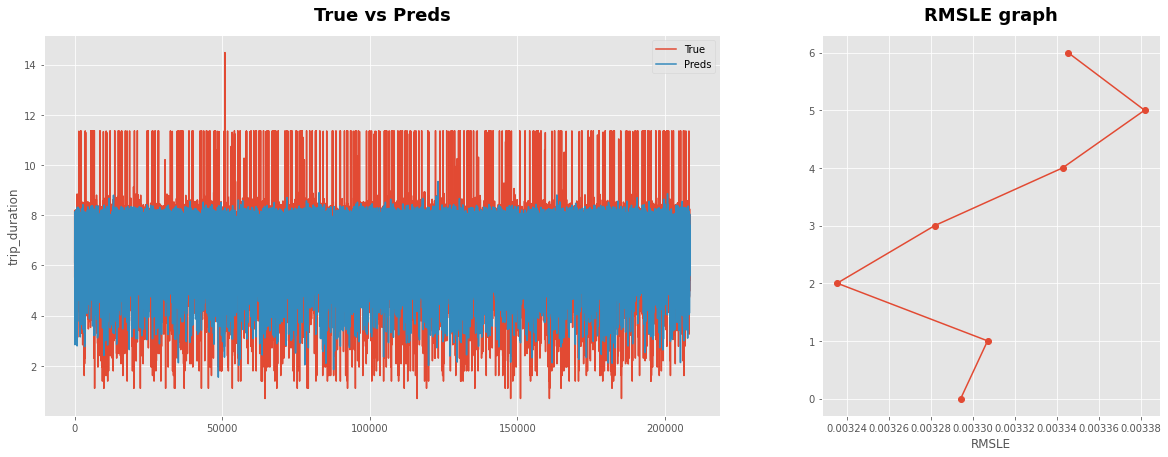

In [73]:
fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=Y_valid.reset_index(drop=True), label='True', ax=ax[0])
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=pd.Series(val_preds), label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

plt.plot(pd.Series(RMSLE), pd.Series(RMSLE).index, marker='o')
plt.title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('RMSLE')

# 이상값은 표현을 잘 못했다. (모델 튜닝을 안했기 때문)


---
# After 하이퍼 파라미터 튜닝(Optuna) ver


In [39]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [40]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-10 05:35:54,723] A new study created in memory with name: no-name-744c736f-e35e-4aed-9002-a68f7135cbca
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-08-10 05:38:01,676] Trial 0 finished with value: 0.39766390925949374 and parameters: {'iterations': 10247, 'learning_rate': 0.13756294698990082, 'reg_lambda': 14.788657755944179, 'subsample': 0.005941420451261004, 'random_strength': 37.535328877745954, 'depth': 5, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 7}. Best is trial 0 with value: 0.39766390925949374.
[I 2021-08-10 05:38:22,013] Trial 1 finished with value: 0.39106285079564135 and parameters: {'iterations': 21199, 'learning_rate': 0.2147690673416526, 'reg_lambda': 57.54024972364973, 'subsample': 0.6176764424293649, 'random_strength': 39.03473726014246, 'depth': 12, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 8}. Best is trial 1 with value: 0.39106285079564135.
[I 2021-08-10 05:39:54,579] Trial

Number of finished trials: 50
Best trial: score 0.3791384069588187, params {'iterations': 12249, 'learning_rate': 0.07265021851686762, 'reg_lambda': 37.472531761492895, 'subsample': 0.9928794653159002, 'random_strength': 25.663185693739496, 'depth': 10, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 13}


In [80]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
RMSLE = {}

params = {
    'iterations':study.best_params['iterations'],
    'loss_function':'RMSE',
    'task_type':"GPU",
    'eval_metric':'RMSE',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth': study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Lossguide'
}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_cat = catboost.CatBoostRegressor(**params)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}\r')

0:	learn: 0.7590332	test: 0.7624609	best: 0.7624609 (0)	total: 25.9ms	remaining: 5m 17s
100:	learn: 0.4083396	test: 0.4133399	best: 0.4133399 (100)	total: 2.5s	remaining: 5m 1s
200:	learn: 0.3965941	test: 0.4028697	best: 0.4028697 (200)	total: 4.79s	remaining: 4m 46s
300:	learn: 0.3907206	test: 0.3988918	best: 0.3988918 (300)	total: 7.08s	remaining: 4m 41s
400:	learn: 0.3863059	test: 0.3965439	best: 0.3965439 (400)	total: 9.34s	remaining: 4m 35s
500:	learn: 0.3826700	test: 0.3945755	best: 0.3945755 (500)	total: 11.5s	remaining: 4m 28s
600:	learn: 0.3794292	test: 0.3931628	best: 0.3931628 (600)	total: 13.6s	remaining: 4m 24s
700:	learn: 0.3768501	test: 0.3919568	best: 0.3919568 (700)	total: 15.9s	remaining: 4m 21s
800:	learn: 0.3743385	test: 0.3909114	best: 0.3909059 (799)	total: 18.1s	remaining: 4m 18s
900:	learn: 0.3719481	test: 0.3899324	best: 0.3899324 (900)	total: 20.4s	remaining: 4m 17s
1000:	learn: 0.3698004	test: 0.3891782	best: 0.3891782 (1000)	total: 22.6s	remaining: 4m 14s
11

Text(0.5, 0, 'RMSLE')

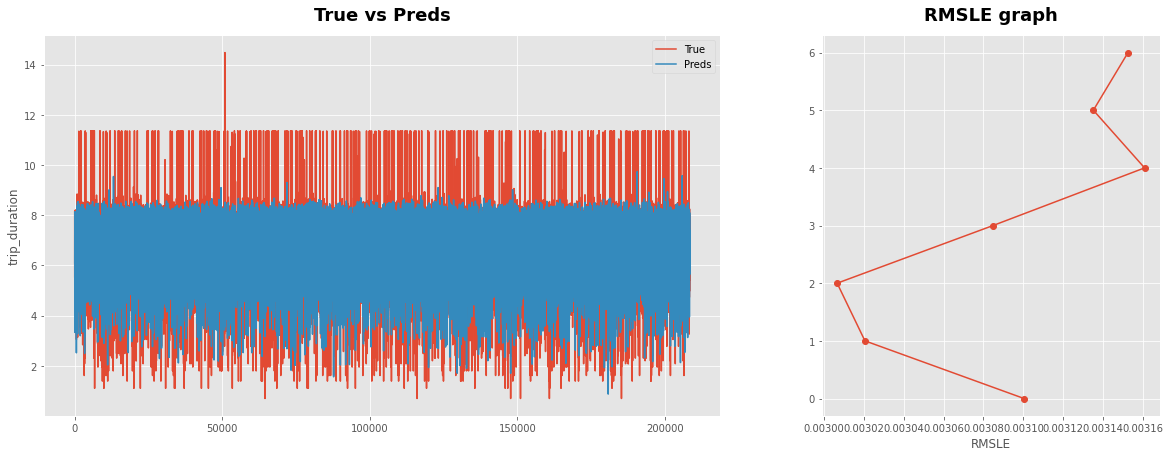

In [81]:
fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=Y_valid.reset_index(drop=True), label='True', ax=ax[0])
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=pd.Series(val_preds), label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

plt.plot(pd.Series(RMSLE), pd.Series(RMSLE).index, marker='o')
plt.title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('RMSLE')

In [82]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')
submit['trip_duration'] = preds
submit

,id,trip_duration
0,id3004672,789.070337
1,id3505355,602.833031
2,id1217141,437.473120
3,id2150126,945.326193
4,id1598245,352.554515
...,...,...
625129,id3008929,312.222245
625130,id3700764,1340.198972
625131,id2568735,1878.199022
625132,id1384355,14505.062189


In [83]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/nyc_submit1.csv', index=False)

# To Do
- 역효과 나는 FE 제거하고 모델링
- 범주형 변수 변경할 것 있으면 변경하고 모델링

# 이 프로젝트를 하면서 느낀 점

- FE(Feature Engineering)는 아이디어 싸움이다!


- 모델링의 성능을 좌우하는 것은 다양한 모델 알고리즘(linear-regression, svm, xgb, catboost, lightbgm...)이 아니라 **세심한 Feature Engineering**이다.
  - 해당 프로젝트 뿐만 아니라 kaggle, dacon competition을 참여 하면서 느낀 점은 FE는 competition점수와 직결 되어있다.
  - 그러나 다양한 FE method들이 있지만 데이터마다 효과가 있는 FE 아이디어들이 있지만, 역효과가 나는 FE method들도 많다.
  - 데이터마다 효과적인 FE method를 찾아야한다.
  - 해당 데이터를 질 높은 데이터 셋으로 만들어야 한다. ==> 꼼꼼한 EDA는 필수!


> "AI를 요리에 비유하자면 data는 food에 해당한다. 품질 좋은 데이터를 사용 한다는 것은 품질 좋은 재료를 가지고 요리를 한다는 것(모델을 학습시킨다는 것)을 의미한다."

> "머신러닝 작업의 80%는 질 좋은 데이터를 구축하는 것이고 20%은 모델을 학습하는 것이다."

> Andrew Ng 교수님